In [24]:
import warnings
warnings.filterwarnings('ignore')

아래와 같이 텍스트 파일을 읽어 옵니다.

In [27]:
import numpy as np
from os import listdir
from os.path import isfile, join

mypath = './example_En_docs/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles.sort()

total_docs = []
for file in onlyfiles:
    file_path = mypath+file
    with open(file_path, 'r', encoding='utf8') as f:
        content = f.read()
    total_docs.append(content)

In [29]:
len(total_docs)

15

In [31]:
total_docs[0]

'Ryen Aleman was engrossed in the virtual world, focused on the video game in front of him, when he realized the gunshots he was hearing were real. He ducked and bolted for a restroom to take cover.\nAnother mass shooting was unfolding in Florida, this time at a tournament for competitive players of the football video game, Madden, in Jacksonville. The winners would go on to a higher level tournament in Las Vegas in October, where large cash prizes could be won.\nParticipants had gathered at the Jacksonville Landing Complex, an open-air marketplace with stores, bars and restaurants along the St. Johns River.\n\nDavid Katz, a 24-year-old gamer from Baltimore, Maryland, was in Jacksonville for the tournament at GLHF Game Bar, in the back of a pizza restaurant. On Sunday, he brought a gun into the venue and opened fire, killing two people. Then he turned the gun on himself, Jacksonville Sheriff Mike Williams said. Police have not released a possible motive.\nKatz used at least one handgun

In [33]:
import re
import nltk
from nltk.corpus import stopwords

def do_En_preprocessing(text, customized_stopwords):
    cleaned_content = re.sub(r'[^\w\d\s]','',text) # To remove symbols
    cleaned_content = cleaned_content.lower() # Case conversion, upper -> lower
    word_tokens = nltk.word_tokenize(cleaned_content) # Tokenization
    tokens_pos = nltk.pos_tag(word_tokens) # POS tagging
    NN_words = []   # To select nouns
    for word, pos in tokens_pos:
        if 'NN' in pos:
            NN_words.append(word)
            
    wlem = nltk.WordNetLemmatizer()   # Lemmatization
    lemmatized_words = []
    for word in NN_words:
        lemmatized_words.append(wlem.lemmatize(word))
    # 불용어 제거    
    stopwords_list = stopwords.words('english')
    unique_NN_words = set(lemmatized_words)
    final_NN_words = lemmatized_words
    for word in unique_NN_words:
        if word in stopwords_list:
            while word in final_NN_words: 
                final_NN_words.remove(word)
    
    unique_NN_words1 = set(final_NN_words)
    for word in unique_NN_words1:
        if word in customized_stopwords:
            while word in final_NN_words: 
                final_NN_words.remove(word)
    
    return final_NN_words

In [34]:
customized_stopwords = ['today', 'yesterday', 'tomorrow'] # 불용어 사전 생성하기

In [35]:
docs_nouns = [do_En_preprocessing(doc, customized_stopwords) for doc in total_docs]

In [36]:
print(docs_nouns[0]) # 첫번째 문서에 대한 내용 ((문서 내용, [명사단어])로 구성)

['aleman', 'world', 'video', 'game', 'front', 'gunshot', 'restroom', 'cover', 'mass', 'shooting', 'florida', 'time', 'tournament', 'player', 'football', 'video', 'game', 'madden', 'jacksonville', 'winner', 'level', 'tournament', 'vega', 'october', 'cash', 'prize', 'participant', 'jacksonville', 'marketplace', 'store', 'bar', 'restaurant', 'st', 'john', 'river', 'david', 'gamer', 'baltimore', 'maryland', 'jacksonville', 'tournament', 'game', 'bar', 'back', 'pizza', 'restaurant', 'sunday', 'gun', 'venue', 'fire', 'people', 'gun', 'mike', 'williams', 'police', 'motive', 'katz', 'handgun', 'sheriff', 'people', 'wound', 'people', 'area', 'williams', 'victim', 'condition', 'hospital', 'sheriff', 'horror', 'stream', 'event', 'game', 'shot', 'people', 'person', 'f', 'whatd', 'call', 'williams', 'officer', 'scene', 'minute', 'bathroom', 'minute', 'ran', 'scene', 'im', 'member', 'jacksonville', 'fire', 'station', 'rock', 'training', 'parking', 'garage', 'street', 'landing', 'dozen', 'people', 'p

In [39]:
documents_filtered = [' '.join(doc) for doc in docs_nouns]
# 불필요한 단어들을 제거하고 난후 DTM로 변환하기 위해 다시 list of strings의 형태로 변환

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
DTM_tfidf = tfidf_vectorizer.fit_transform(documents_filtered)
DTM_TFIDF = np.array(DTM_tfidf.todense())

In [41]:
DTM_TFIDF.shape

(15, 1166)

---------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------

## PCA (차원축소) 

In [49]:
from sklearn.decomposition import PCA

In [61]:
# 10개의 주성분 추출
pca = PCA(n_components=10)   ## 10차원으로 차원 축소
pca_results_tfidf = pca.fit_transform(DTM_TFIDF)

In [63]:
pca_results_tfidf.shape

(15, 10)

## KMeans 적용하기

In [59]:
from sklearn.cluster import KMeans

In [63]:
kmeans = KMeans(n_clusters=5)
clusters_pca_tfidf = kmeans.fit_predict(pca_results_tfidf)

In [64]:
clusters_pca_tfidf

array([3, 3, 4, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2])

## 실루엣 값 확인해 보기

In [72]:
from sklearn.metrics import silhouette_score
print(silhouette_score(pca_results_tfidf, clusters_pca_tfidf))
# PCA 군집화에 대한 실루엣 값이 더 큼

0.2630084023861993


In [74]:
kmeans1 = KMeans(n_clusters=5, random_state=42)
clusters_tfidf = kmeans1.fit_predict(DTM_TFIDF)

In [75]:
clusters_tfidf

array([2, 2, 2, 0, 0, 0, 0, 0, 1, 4, 4, 1, 3, 3, 3])

In [76]:
print(silhouette_score(DTM_TFIDF, clusters_tfidf))

0.16898785419367665


## 군집화 분석 결과 시각화 해보기

In [81]:
pca = PCA(n_components=2)
pca_results_tfidf = pca.fit_transform(DTM_TFIDF)

In [83]:
kmeans = KMeans(n_clusters=5)
clusters_pca_tfidf = kmeans.fit_predict(pca_results_tfidf)

In [85]:
clusters_pca_tfidf

array([4, 4, 4, 2, 2, 3, 3, 3, 1, 1, 1, 1, 0, 0, 0])

### 시각화

In [88]:
import pandas as pd

In [90]:
pca_results_tfidf 

array([[ 0.19993884,  0.04683196],
       [ 0.20542308,  0.05517693],
       [ 0.20753343,  0.02710393],
       [ 0.11766418,  0.23363549],
       [ 0.08632095,  0.26418947],
       [-0.20095112,  0.59100531],
       [-0.20698889,  0.52503773],
       [-0.2106596 ,  0.60580172],
       [-0.55053822, -0.45081471],
       [-0.37438779, -0.26401503],
       [-0.45004873, -0.3696668 ],
       [-0.51019192, -0.44443496],
       [ 0.57862858, -0.28907323],
       [ 0.53951111, -0.25425977],
       [ 0.5687461 , -0.27651803]])

In [92]:
data = pd.DataFrame(pca_results_tfidf, columns=['x1', 'x2'])

In [94]:
data['cluster_id']=clusters_pca_tfidf.tolist()

In [96]:
data.head(3)

,x1,x2,cluster_id
0,0.199939,0.046832,4
1,0.205423,0.055177,4
2,0.207533,0.027104,4


In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

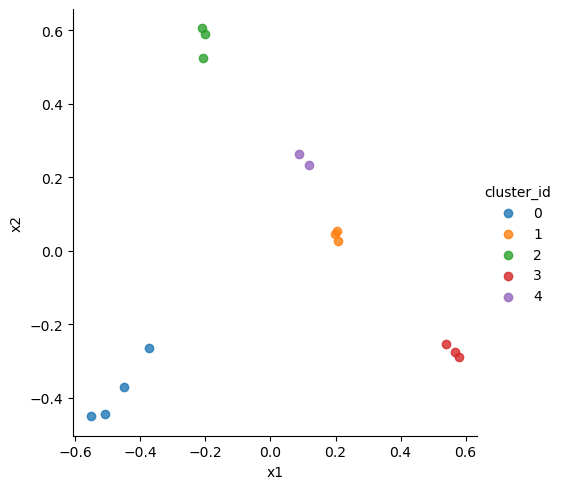

In [51]:
sns.lmplot(x='x1', y='x2', data=data, hue='cluster_id',fit_reg=False )
plt.show()

## 3차원의 형태로 시각화 하기

In [100]:
pca = PCA(n_components=3)
pca_results_tfidf = pca.fit_transform(DTM_TFIDF)

In [102]:
kmeans = KMeans(n_clusters=5)
clusters_pca_tfidf = kmeans.fit_predict(pca_results_tfidf)

In [103]:
data = pd.DataFrame(pca_results_tfidf, columns=['x1', 'x2', 'x3'])
data['cluster_id']=clusters_pca_tfidf.tolist()

In [106]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

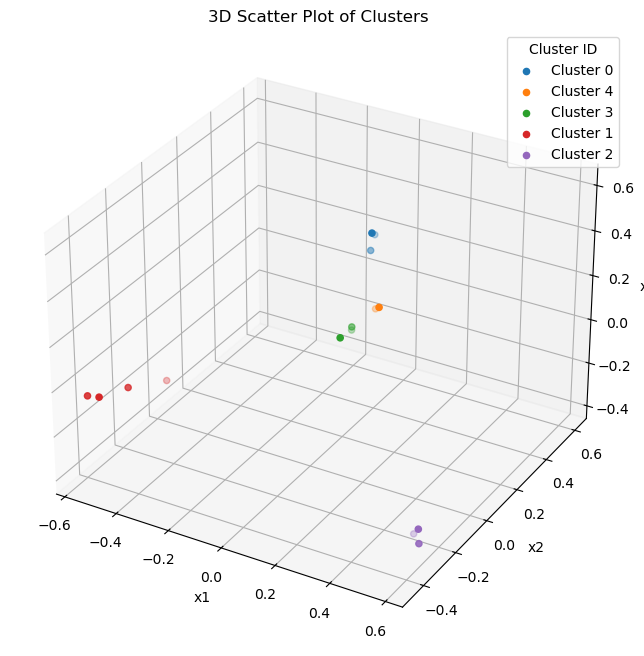

In [118]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define colors based on clusters
clusters = data['cluster_id'].unique()
colors = sns.color_palette(n_colors=len(clusters))

for cluster, color in zip(clusters, colors):
    subset = data[data['cluster_id'] == cluster]
    ax.scatter(subset['x1'], subset['x2'], subset['x3'], label=f'Cluster {cluster}', color=color)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.legend(title='Cluster ID')

plt.title('3D Scatter Plot of Clusters')
plt.show()